# 02 - Stratégies de Vectorisation

**Objectif**: Trouver la meilleure méthode de représentation des features textuelles.

**Méthodologie**:
- **Modèle fixé**: Logistic Regression (contrôle de variable)
- **Preprocessing**: `final_text_cleaner()` (from Notebook 01)
- **Variables testées**: Vectorizer, Features, Strategy, Hyperparamètres

**Output**: Configuration optimale → `configs/best_vectorization_config.json`

## 1. Setup & Configuration

In [15]:
import sys
print(sys.executable)

c:\Users\xiaos\anaconda3\envs\rakuten_groupe\python.exe


In [16]:
import sys
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, '../src')

# Imports Phase 2
from rakuten_text import (
    # Preprocessing (Phase 1)
    final_text_cleaner,
    
    # Features
    extract_text_features,
    get_feature_names,
    
    # Vectorization
    save_vectorization_config,
    
    # Experiments
    run_single_experiment,
    run_strategy_comparison,
    run_hyperparameter_grid,
    run_title_weighting_experiment,
    analyze_experiment_results,
    generate_vectorization_report,
)

from sklearn.model_selection import train_test_split

print("✓ Imports réussis")

✓ Imports réussis


## 2. Chargement et Preprocessing

In [17]:
# Charger données
print("Chargement...")
X_train_full = pd.read_csv('../data/raw/X_train_update.csv', index_col=0)
y_train_full = pd.read_csv('../data/raw/Y_train_CVw08PX.csv', index_col=0)['prdtypecode']

print(f"✓ {X_train_full.shape[0]} échantillons, {y_train_full.nunique()} classes")

# Appliquer preprocessing optimal (from Notebook 01)
print("\nPreprocessing avec final_text_cleaner()...")
X_train_full['title_clean'] = X_train_full['designation'].fillna('').apply(final_text_cleaner)
X_train_full['desc_clean'] = X_train_full['description'].fillna('').apply(final_text_cleaner)

print("✓ Textes nettoyés")

Chargement...
✓ 84916 échantillons, 27 classes

Preprocessing avec final_text_cleaner()...
✓ Textes nettoyés


## 3. Feature Engineering

In [18]:
# Extraire features manuelles
print("Extraction des features manuelles...")
features = extract_text_features(
    X_train_full,
    text_columns=['designation', 'description'],
    verbose=True
)

# Ajouter au DataFrame
for col in features.columns:
    X_train_full[col] = features[col]

feature_columns = list(features.columns)
print(f"\n✓ {len(feature_columns)} features extraites")
print(f"Features: {feature_columns[:3]}...")

Extraction des features manuelles...
Extraction des features manuelles...
  Colonnes à analyser: ['designation', 'description']
  → Traitement de 'designation'...
  → Traitement de 'description'...
✓ Extraction terminée: 12 features créées
  Noms: ['designation_len_char', 'designation_len_words', 'designation_num_digits']...

✓ 12 features extraites
Features: ['designation_len_char', 'designation_len_words', 'designation_num_digits']...


## 4. Train/Val Split

In [19]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.15,
    stratify=y_train_full,
    random_state=42
)

print(f"Train: {len(X_train)} | Val: {len(X_val)}")

Train: 72178 | Val: 12738


## 5. Expérience 1: Comparaison Vectorization Methods

Test: Count vs TF-IDF (sans features manuelles)

In [20]:
# baseline_raw_f1 from Notebook 01
baseline_f1 = 0.7925

print("Test 1: Count vs TF-IDF (Split, sans features)\n")

results_vec = []

# TF-IDF Split
result_tfidf = run_single_experiment(
    X_train, X_val, y_train, y_val,
    vectorizer_type='tfidf',
    strategy='split',
    text_columns=['title_clean', 'desc_clean'],
    feature_columns=None,
    max_features=10000,
    ngram_range=(1, 2),
    model_name='logreg',
    verbose=True
)

results_vec.append({
    'method': 'TF-IDF Split',
    'f1_score': result_tfidf['f1_score'],
    'accuracy': result_tfidf['accuracy']
})

# Count Split
result_count = run_single_experiment(
    X_train, X_val, y_train, y_val,
    vectorizer_type='count',
    strategy='split',
    text_columns=['title_clean', 'desc_clean'],
    feature_columns=None,
    max_features=10000,
    ngram_range=(1, 2),
    model_name='logreg',
    verbose=True
)

results_vec.append({
    'method': 'Count Split',
    'f1_score': result_count['f1_score'],
    'accuracy': result_count['accuracy']
})

df_vec = pd.DataFrame(results_vec)
print("\n" + "="*60)
print("RÉSULTATS:")
print(df_vec.to_string(index=False))
print("="*60)

Test 1: Count vs TF-IDF (Split, sans features)


Expérience: TFIDF + LOGREG
  Strategy: split
  Max features: 10000
  N-gram range: (1, 2)
  Features manuelles: Non

Entraînement du pipeline...
✓ Entraînement terminé en 24.54s

RÉSULTATS DE L'ÉVALUATION
F1-Score (weighted): 0.8283
Accuracy:            0.8282
Temps prédiction:    1.85s

Rapport de classification:
--------------------------------------------------------------------------------
                        precision    recall  f1-score   support

     Livres techniques       0.47      0.62      0.54       467
          Rétro Gaming       0.77      0.68      0.72       376
        Accessoires JV       0.85      0.87      0.86       252
              Consoles       0.98      0.77      0.86       125
              Figurine       0.77      0.79      0.78       401
Cartes à collectionner       0.91      0.93      0.92       593
          Jeux de rôle       0.83      0.48      0.61       115
    Jouets & Figurines       0.74      0.

## 6. Expérience 2: Split vs Merged Strategy

Comparaison détaillée des deux stratégies

In [21]:
print("Test 2: Split vs Merged (TF-IDF)\n")

# Créer colonne merged pour test
X_train['text_merged'] = X_train['title_clean'] + ' ' + X_train['desc_clean']
X_val['text_merged'] = X_val['title_clean'] + ' ' + X_val['desc_clean']

# TF-IDF Merged
result_merged = run_single_experiment(
    X_train, X_val, y_train, y_val,
    vectorizer_type='tfidf',
    strategy='merged',
    text_columns=['text_merged'],
    feature_columns=None,
    max_features=10000,
    ngram_range=(1, 2),
    model_name='logreg',
    verbose=True
)

print("\n" + "="*60)
print("COMPARAISON Split vs Merged:")
print(f"  Split:  F1 = {result_tfidf['f1_score']:.4f}")
print(f"  Merged: F1 = {result_merged['f1_score']:.4f}")
improvement = (result_tfidf['f1_score'] - result_merged['f1_score']) / result_merged['f1_score'] * 100
print(f"  → Split est {improvement:+.2f}% meilleur")
print("="*60)

Test 2: Split vs Merged (TF-IDF)


Expérience: TFIDF + LOGREG
  Strategy: merged
  Max features: 10000
  N-gram range: (1, 2)
  Features manuelles: Non

Entraînement du pipeline...
✓ Entraînement terminé en 25.27s

RÉSULTATS DE L'ÉVALUATION
F1-Score (weighted): 0.7883
Accuracy:            0.7889
Temps prédiction:    2.11s

Rapport de classification:
--------------------------------------------------------------------------------
                        precision    recall  f1-score   support

     Livres techniques       0.41      0.56      0.47       467
          Rétro Gaming       0.74      0.60      0.66       376
        Accessoires JV       0.82      0.82      0.82       252
              Consoles       0.99      0.77      0.86       125
              Figurine       0.74      0.75      0.74       401
Cartes à collectionner       0.87      0.89      0.88       593
          Jeux de rôle       0.74      0.40      0.52       115
    Jouets & Figurines       0.69      0.62      0.65 

## 6b. Expérience 2b: Pondération du Titre

**Question**: Le titre contient-il plus d'information discriminante que la description?

**Test**: Pondérer les features du titre par un facteur multiplicatif (1x à 3x)

In [22]:
print("Test 2b: Pondération du Titre (TF-IDF Split)\n")

# Tester différents poids pour le titre: 1x, 1.5x, 2x, 2.5x, 3x
results_weighting = run_title_weighting_experiment(
    X_train, X_val, y_train, y_val,
    text_columns=['title_clean', 'desc_clean'],
    feature_columns=None,  # Sans features manuelles pour isoler l'effet
    title_weights=[1.0, 1.5, 2.0, 2.5, 3.0],
    vectorizer_type='tfidf',
    max_features=10000,
    ngram_range=(1, 2),
    model_name='logreg',
    verbose=True
)

print("\n✓ Test de pondération terminé")

Test 2b: Pondération du Titre (TF-IDF Split)


TEST DE PONDÉRATION DU TITRE
Poids à tester: [1.0, 1.5, 2.0, 2.5, 3.0]
Vectorizer: TFIDF
Max features: 10000 (par colonne)
N-gram range: (1, 2)
Modèle: LOGREG


[1/5] Test avec title_weight = 1.0x
--------------------------------------------------------------------------------
  → F1-Score: 0.8283
  → Accuracy: 0.8282
  → Train time: 23.90s

[2/5] Test avec title_weight = 1.5x
--------------------------------------------------------------------------------
  → F1-Score: 0.8350
  → Accuracy: 0.8350
  → Train time: 19.12s

[3/5] Test avec title_weight = 2.0x
--------------------------------------------------------------------------------
  → F1-Score: 0.8350
  → Accuracy: 0.8348
  → Train time: 23.52s

[4/5] Test avec title_weight = 2.5x
--------------------------------------------------------------------------------
  → F1-Score: 0.8321
  → Accuracy: 0.8319
  → Train time: 24.42s

[5/5] Test avec title_weight = 3.0x
------------------------

## 7. Expérience 3: Impact des Features Manuelles

Test des 5 stratégies complètes

In [23]:
print("Test 3: Impact des features manuelles\n")

# Utiliser la fonction run_strategy_comparison
results_strategies = run_strategy_comparison(
    X_train, X_val, y_train, y_val,
    text_columns=['title_clean', 'desc_clean'],
    feature_columns=feature_columns,
    models=['logreg'],  # Seul LogReg pour contrôle
    max_features=10000,
    ngram_range=(1, 2),
    verbose=True
)

print("\n✓ Comparaison terminée")

Test 3: Impact des features manuelles


COMPARAISON COMPLÈTE DES STRATÉGIES DE VECTORISATION
Modèles à tester: ['logreg']
Max features: 10000
N-gram range: (1, 2)


📊 STRATÉGIE 1: Indicateurs seuls
--------------------------------------------------------------------------------
  Modèle: LOGREG
    F1: 0.2926, Acc: 0.3403


📊 STRATÉGIE 2: CountVectorizer seul
--------------------------------------------------------------------------------
  Modèle: LOGREG

Expérience: COUNT + LOGREG
  Strategy: split
  Max features: 10000
  N-gram range: (1, 2)
  Features manuelles: Non

    F1: 0.8205, Acc: 0.8191


📊 STRATÉGIE 3: TF-IDF seul
--------------------------------------------------------------------------------
  Modèle: LOGREG

Expérience: TFIDF + LOGREG
  Strategy: split
  Max features: 10000
  N-gram range: (1, 2)
  Features manuelles: Non

    F1: 0.8283, Acc: 0.8282


📊 STRATÉGIE 4: Indicateurs + CountVectorizer
--------------------------------------------------------------------------

## 8. Expérience 4: Grid Search Hyperparamètres

Optimisation de max_features et ngram_range

In [24]:
# Déterminer le meilleur vectorizer depuis Exp 3
best_from_exp3 = results_strategies.iloc[0]
best_vectorizer_type = best_from_exp3['vectorizer']
use_features = best_from_exp3['use_features']

# Extraire le meilleur title_weight depuis Exp 2b
best_title_weight = results_weighting.iloc[0]['title_weight']

print(f"Grid search avec:")
print(f"  Vectorizer: {best_vectorizer_type}")
print(f"  Features: {use_features}")
print(f"  Title weight: {best_title_weight}x (optimal de Exp 2b)")
print()

# Grid search avec title_weight optimal
grid_results = run_hyperparameter_grid(
    X_train, X_val, y_train, y_val,
    vectorizer_type=best_vectorizer_type if best_vectorizer_type != 'None' else 'tfidf',
    max_features_list=[5000, 10000, 15000, 20000],
    ngram_range_list=[(1, 1), (1, 2), (1, 3)],
    model_name='logreg',
    text_columns=['title_clean', 'desc_clean'],
    feature_columns=feature_columns if use_features else None,
    title_weight=best_title_weight,
    verbose=True
)

Grid search avec:
  Vectorizer: tfidf
  Features: True
  Title weight: 1.5x (optimal de Exp 2b)


GRID SEARCH: TFIDF Hyperparameters
Total expériences: 12
  max_features: [5000, 10000, 15000, 20000]
  ngram_range: [(1, 1), (1, 2), (1, 3)]
  title_weight: 1.5
  model: logreg

[1/12] max_features=5000, ngram_range=(1, 1)

Expérience: TFIDF + LOGREG
  Strategy: split
  Max features: 5000
  N-gram range: (1, 1)
  Features manuelles: Oui

  → F1: 0.8285, Acc: 0.8286

[2/12] max_features=5000, ngram_range=(1, 2)

Expérience: TFIDF + LOGREG
  Strategy: split
  Max features: 5000
  N-gram range: (1, 2)
  Features manuelles: Oui

  → F1: 0.8241, Acc: 0.8243

[3/12] max_features=5000, ngram_range=(1, 3)

Expérience: TFIDF + LOGREG
  Strategy: split
  Max features: 5000
  N-gram range: (1, 3)
  Features manuelles: Oui

  → F1: 0.8213, Acc: 0.8213

[4/12] max_features=10000, ngram_range=(1, 1)

Expérience: TFIDF + LOGREG
  Strategy: split
  Max features: 10000
  N-gram range: (1, 1)
  Features man

## 9. Analyse & Visualisation


ANALYSE DES RÉSULTATS

Nombre d'expériences: 12
F1-Score moyen: 0.8366
F1-Score médian: 0.8398
F1-Score min: 0.8213
F1-Score max: 0.8444
Écart-type: 0.0080

Baseline F1: 0.7925
Expériences supérieures à baseline: 12 / 12
Meilleure amélioration: +6.55%

--------------------------------------------------------------------------------
PERFORMANCE PAR MODÈLE:
--------------------------------------------------------------------------------
            mean       max  count
model                            
logreg  0.836636  0.844429     12


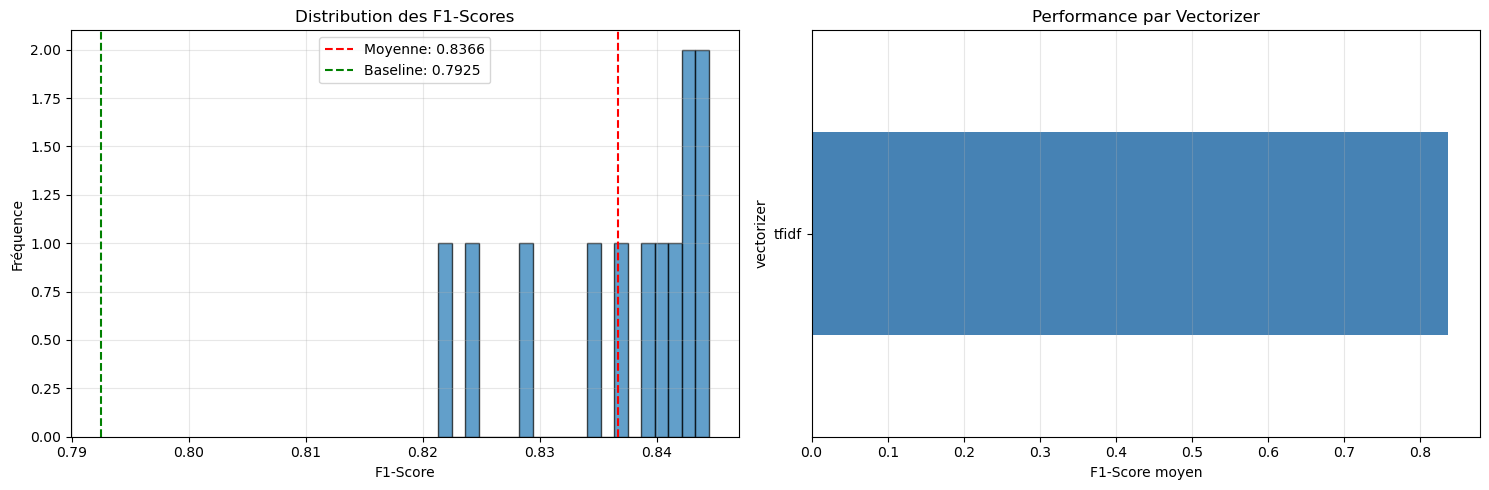

In [25]:
# Analyser grid results
analyze_experiment_results(
    grid_results,
    baseline_f1=baseline_f1,
    show_plot=True
)

## 10. Configuration Optimale

Identification et sauvegarde de la meilleure configuration

In [26]:
# Meilleure configuration
best = grid_results.iloc[0]

print("="*80)
print("🏆 CONFIGURATION OPTIMALE")
print("="*80)
print(f"Vectorizer: {best['vectorizer'].upper()}")
print(f"Max features: {best['max_features']}")
print(f"N-gram range: {best['ngram_range']}")
print(f"Features manuelles: {'Oui' if best['use_features'] else 'Non'}")
print(f"\nPerformance:")
print(f"  F1-Score: {best['f1_score']:.4f}")
print(f"  Accuracy: {best['accuracy']:.4f}")
improvement_vs_baseline = (best['f1_score'] - baseline_f1) / baseline_f1 * 100
print(f"  Amélioration vs baseline: {improvement_vs_baseline:+.2f}%")
print("="*80)

🏆 CONFIGURATION OPTIMALE
Vectorizer: TFIDF
Max features: 20000
N-gram range: (1, 1)
Features manuelles: Oui

Performance:
  F1-Score: 0.8444
  Accuracy: 0.8445
  Amélioration vs baseline: +6.55%


## 11. Export Configuration

Sauvegarder pour Notebook 03

In [27]:
# Construire le dictionnaire de configuration
import ast

ngram_tuple = ast.literal_eval(best['ngram_range']) if isinstance(best['ngram_range'], str) else best['ngram_range']

BEST_CONFIG = {
    'vectorizer_type': best['vectorizer'],
    'strategy': 'split',
    'text_columns': ['title_clean', 'desc_clean'],
    'feature_columns': feature_columns if best['use_features'] else None,
    'max_features_title': int(best['max_features']),
    'max_features_desc': int(best['max_features']),
    'ngram_range': ngram_tuple,
    'title_weight': float(best.get('title_weight', 1.0)),
    'min_df': 2,
    'max_df': 0.95
}

# Sauvegarder
save_vectorization_config(
    BEST_CONFIG,
    'results/configs/best_vectorization_config.json',
    metadata={
        'f1_score': float(best['f1_score']),
        'accuracy': float(best['accuracy']),
        'train_time': float(best['train_time']),
        'notebook': '02_Vectorization_Strategies.ipynb',
        'baseline_f1': baseline_f1,
        'improvement_pct': float(improvement_vs_baseline),
        'title_weight': float(best.get('title_weight', 1.0))
    }
)

print("\n✓ Configuration exportée vers: results/configs/best_vectorization_config.json")
print("✓ Prête pour Notebook 03 (Model Selection)")

✓ Configuration sauvegardée: results/configs/best_vectorization_config.json

✓ Configuration exportée vers: results/configs/best_vectorization_config.json
✓ Prête pour Notebook 03 (Model Selection)


## 12. Conclusions & Rapport Final

**Génération automatique** du rapport complet avec:
- ✅ Tracking global de tous les scores
- ✅ Vérification de l'optimalité de la configuration
- ✅ Résumé détaillé des 5 découvertes principales
- ✅ Performance finale et prochaines étapes

Le rapport est affiché ci-dessous et sauvegardé dans `results/vectorization_report.txt`.

In [28]:
# ============================================================================
# GÉNÉRATION DU RAPPORT COMPLET
# ============================================================================

report = generate_vectorization_report(
    df_vec=df_vec,
    results_weighting=results_weighting,
    results_strategies=results_strategies,
    grid_results=grid_results,
    result_tfidf=result_tfidf,
    result_merged=result_merged,
    baseline_f1=baseline_f1,
    save_report=True,
    report_path='results/vectorization_report.txt',
    verbose=True
)

# Résumé rapide
print("\n" + "="*80)
print("RÉSUMÉ RAPIDE")
print("="*80)
print(f"✓ Configuration optimale: {'✅ OUI' if report['is_optimal'] else '⚠️ NON'}")
print(f"✓ Meilleur F1 score: {report['best_score']:.4f}")
print(f"✓ Baseline F1: {report['baseline_score']:.4f}")
print(f"✓ Amélioration totale: +{report['total_improvement_pct']:.2f}%")
print(f"\n✓ Rapport sauvegardé: results/vectorization_report.txt")
print(f"✓ Tracking sauvegardé: results/all_scores_tracking.csv")
print("="*80)


✓ Rapport sauvegardé: results/vectorization_report.txt

📊 RAPPORT DE VECTORISATION - PHASE 2
Généré le: 2025-12-10 20:28:16
Total expériences: 24

RÉSUMÉ DES DÉCOUVERTES

1️⃣  Count vs TF-IDF
   → TF-IDF (F1=0.8283) surpasse Count (F1=0.8205)
   → Amélioration: +0.95%

2️⃣  Split vs Merged
   → Split (F1=0.8283) surpasse Merged (F1=0.7883)
   → Amélioration: +5.08%

3️⃣  Pondération du Titre
   → Poids optimal: 1.5x
   → F1 = 0.8350 (baseline 1.0x: 0.8283)
   → Amélioration: +0.80%

4️⃣  Features Manuelles
   → Sans features: F1 = 0.8283
   → Avec features: F1 = 0.8332
   → Amélioration: +0.59%

5️⃣  Hyperparamètres Optimaux
   → Vectorizer: TFIDF
   → Max features: 20,000
   → N-gram range: (1, 1)
   → Title weight: 1.5x
   → Features manuelles: Oui
   → F1 Final: 0.8444

🏆 PERFORMANCE FINALE
Baseline (raw data, NB01):              F1 = 0.7925
Meilleur score (configuration finale):  F1 = 0.8444
Amélioration totale:                    +6.55%

Statut: ✅ Configuration optimale validée

